In [1]:
import geojson
import shapely
import stageemi
import stageemi.dev.visu as dev
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import stageemi.dev.decorator_map as dm
import ipywidgets as widg 
import ipyleaflet as ipyl
import datetime as dt
import os 
from ipywidgets import Text, HTML
from ipyleaflet import WidgetControl
import pandas 

In [22]:
date="20200122"
hr="120000"
path="/scratch/labia/lepapeb/StageEMI/"

In [23]:
fileDD=path+"DD"+"/20200122120000__PAROME__DD__EURW1S100______GRILLE____0_48_1__HAUTEUR__10__.nc"
fileFF=path+"FF"+"/20200122120000__PAROME__FF__EURW1S100______GRILLE____0_48_1__HAUTEUR__10__.nc"
filePR=path+"PRECIP"+"/20200122120000__PAROME__PRECIP__EURW1S100______GRILLE____1_48_1__SOL____.nc"
fileWW=path+"WWMF"+"/20200122120000__PG0PAROME__WWMF__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc"

In [24]:
latmin=43
latmax=44
lonmin=2
lonmax=5
subsampgeo=1
subsampt=3 # make sure this value is odd

In [25]:
ds_dd=xr.open_dataset(fileDD)
ds_dd_sub=ds_dd.sel(latitude=slice(latmax,latmin,subsampgeo)).sel(longitude=slice(lonmin,lonmax,subsampgeo)).coarsen(step=subsampt,boundary="trim").mean()

ds_ff=xr.open_dataset(fileFF)
ds_ff_sub=ds_ff.sel(latitude=slice(latmax,latmin,subsampgeo)).sel(longitude=slice(lonmin,lonmax,subsampgeo)).coarsen(step=subsampt,boundary="trim").mean()

ds_pr=xr.open_dataset(filePR)
ds_pr_sub=ds_pr.sel(latitude=slice(latmax,latmin,subsampgeo)).sel(longitude=slice(lonmin,lonmax,subsampgeo)).coarsen(step=subsampt,boundary="trim").mean()

# Be careful about how you do the subsampling for 'WWMF' (tps sensible)
# Here .median works because subsampt=3 (odd nb)
ds_ww=xr.open_dataset(fileWW)
ds_ww_sub=ds_ww.sel(latitude=slice(latmax,latmin,subsampgeo)).sel(longitude=slice(lonmin,lonmax,subsampgeo)).coarsen(step=subsampt,boundary="trim").median()

In [ ]:
fig=plt.figure(figsize=(15,7))
plt.subplot(2, 2, 1)
ds_dd_sub.p3031[0].plot()
plt.subplot(2, 2, 2)
ds_ff_sub.ws[0].plot()
plt.subplot(2, 2, 3)
ds_pr_sub.tp[0].plot()
plt.subplot(2, 2, 4)
ds_ww_sub.unknown[0].plot()
plt.tight_layout()

In [ ]:
fig=plt.figure(figsize=(15,7))
plt.subplot(2, 2, 1)
ds_dd_sub.p3031[0].plot()
plt.subplot(2, 2, 2)
ds_dd_sub.p3031[4].plot()
plt.subplot(2, 2, 3)
ds_dd_sub.p3031[8].plot()
plt.subplot(2, 2, 4)
ds_dd_sub.p3031[12].plot()
plt.tight_layout()

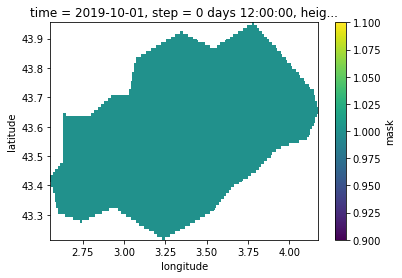

In [26]:
mask = 'FRJ13' #['FRB05' Loir-et-Cher,"FRH02" Finistere,'FRJ13' Herault,'FRK24' Isere]
fname_mask = '../GeoData/nc_departement/'+mask+'.nc'
ds_mask = xr.open_dataset(fname_mask)
ds_mask["latitude"]=ds_mask["latitude"].round(5)
ds_mask["longitude"]=ds_mask["longitude"].round(5)
lat_center = ds_mask["latitude"].values.mean()
lon_center = ds_mask["longitude"].values.mean()
ds_mask.mask.plot()
#ds_mask

In [7]:
mask = '3408' #Zone sympo
fname_mask = '../../../StageEMI_masks/Masques_netcdf/ZONE_SYMPO/'+mask+'.nc'
ds_mask = xr.open_dataset(fname_mask)
ds_mask["latitude"]=ds_mask["latitude"].round(5)
ds_mask["longitude"]=ds_mask["longitude"].round(5)
lat_center = ds_mask["latitude"].values.mean()
lon_center = ds_mask["longitude"].values.mean()
# ds_mask.mask.plot()
#ds_mask

In [ ]:
#ds_dd_sub['latitude']=ds_dd_sub['latitude'].round(5)
#ds_dd_sub['longitude']=ds_dd_sub['longitude'].round(5)

#ds_dd_h=ds_dd_sub*ds_mask["mask"].squeeze("id")
#ds_dd_h.p3031.isel(step=0).plot.imshow()

In [27]:
def  majoritaire(data, code,legende):
    """code borrowed from Mary to find the majoritary temps sensible within a zone, code can be WWMF or WME"""
    occurence   = np.asarray([np.sum(data == code[i]) for i in range(code.size)])
    code_majoritaire = code[occurence.argmax()]
    leg_majoritaire  = legende[occurence.argmax()]
#     print(np.sort(occurence)[::-1])
#     print(np.argsort(occurence)[::-1])
    return code_majoritaire, leg_majoritaire

In [28]:
# Lecture des codes WWMF pour chercher le temps majoritaire
file_CodesWWMF = '../utils/CodesWWMF.csv'
df = pandas.read_csv(file_CodesWWMF,usecols = (0,1,2,3,6,7),sep=',')
legende_WWMF = df['Legende WWMF'].to_numpy()
code_WWMF    = df['Code WWMF'].to_numpy()
df

,Code WWMF,Legende WWMF,Code W1,Legende W1,Code WME,Legende WME
0,-1,Inconnu,-1,Inconnu,-1,Inconnu
1,0,Clair,0,RAS,1,Clair/Peu nuageux
2,1,Peu nuageux,0,RAS,1,Clair/Peu nuageux
3,2,Nuageux,0,RAS,2,Nuageux
4,3,Très nuageux,0,RAS,3,Très nuageux/Couvert
5,4,Couvert,0,RAS,3,Très nuageux/Couvert
6,5,Variable,0,RAS,2,Nuageux
7,6,Voilé,0,RAS,2,Nuageux
8,10,Sable,0,RAS,-1,Inconnu
9,15,Trombe,0,RAS,-1,Inconnu


In [153]:
ds_ww_sub['latitude']=ds_ww_sub['latitude'].round(5)
ds_ww_sub['longitude']=ds_ww_sub['longitude'].round(5)

ds_ww_h=ds_ww_sub*ds_mask["mask"].squeeze("id")
ds_ww_h

<xarray.Dataset>
Dimensions:            (latitude: 74, longitude: 162, step: 16)
Coordinates:
  * latitude           (latitude) float64 43.95 43.94 43.93 ... 43.23 43.22
  * longitude          (longitude) float64 2.56 2.57 2.58 ... 4.15 4.16 4.17
  * step               (step) timedelta64[ns] 02:00:00 ... 1 days 23:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'
Data variables:
    unknown            (step, latitude, longitude) float32 nan nan ... nan nan

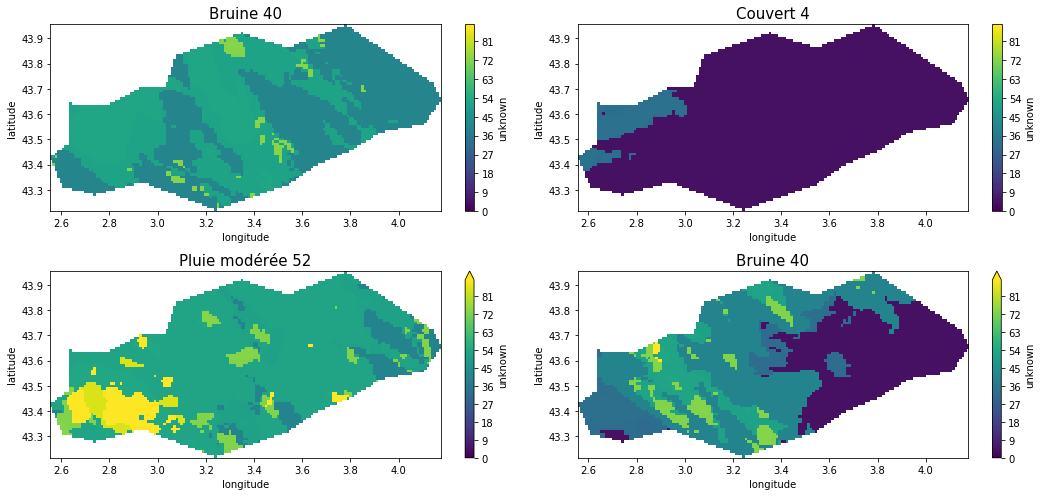

In [357]:
fig,axes = plt.subplots(nrows=2,ncols = 2,figsize=(15,7))
ax = axes.flat
for i in range(4):
    val = ds_ww_h.unknown.isel(step=4*i).copy()
    code,leg = majoritaire(val.values, code_WWMF,legende_WWMF)
    val.plot.imshow(ax=ax[i],levels=range(0,90))
    ax[i].set_title(leg+' ' + str(code),fontsize=15)
plt.tight_layout()

In [11]:
# testing the conversion + distance functions
file_CodesCOMPASS = '../utils/distance_compas.csv'
df_compass = pandas.read_csv(file_CodesCOMPASS,sep=',')
file_CodesWWMF= '../utils/CodesWWMF.csv'
df_WWMF = pandas.read_csv(file_CodesWWMF,usecols = (0,1,6,7),sep=',')
df_compass
#df_WWMF

,Codes WME,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1,0,2,6,4,4,7,7,8,10,8,10,3,3,6,6,8,8,8,8
1,2,2,0,3,2,2,5,5,7,9,7,9,2,2,4,4,6,6,5,5
2,3,6,3,0,1,1,2,2,4,7,4,7,4,4,4,4,4,4,5,5
3,4,4,2,1,0,1,4,5,6,7,7,8,5,6,5,6,5,5,5,5
4,5,4,2,1,1,0,5,4,7,8,6,7,6,5,6,5,5,5,5,5
5,6,7,5,2,4,5,0,2,2,4,4,7,4,5,3,4,4,4,6,7
6,7,7,5,2,5,4,2,0,3,5,2,4,5,4,4,3,5,5,6,4
7,8,8,7,4,6,7,2,3,0,1,2,3,5,6,2,3,2,1,3,5
8,9,10,9,7,7,8,4,5,1,0,3,2,7,8,4,5,3,2,3,4
9,10,8,7,4,7,6,4,2,2,3,0,1,6,5,3,2,4,6,5,3


In [60]:
# used to test that the conversion function works successfully
ds_test=ds_ww_h.sel(latitude=slice(43.6,43.57)).sel(longitude=slice(3,3.02)).isel(step=0)
ds_test.unknown
conversion(ds_test)
ds_test.wme_arr # shall see that the wwmf code has been converted into the wme code

<xarray.DataArray 'wme_arr' (latitude: 4, longitude: 3)>
array([[8., 8., 8.],
       [8., 8., 6.],
       [8., 8., 6.],
       [6., 6., 6.]], dtype=float32)
Coordinates:
  * latitude           (latitude) float64 43.6 43.59 43.58 43.57
  * longitude          (longitude) float64 3.0 3.01 3.02
    step               timedelta64[ns] 02:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'

In [63]:
# used to test that the distance function works successfully
#ds_test
distance(ds_test,"compas",action="test")
ds_test["2"] # one shall read new variables: exemple, 4: "1" till "4" with the command: if iwme>0 and iwme<5
#ds_test.wme_arr.isel(step=1)
#ds_test.isel(step=0)

<xarray.DataArray '2' (latitude: 4, longitude: 3)>
array([[7., 7., 7.],
       [7., 7., 5.],
       [7., 7., 5.],
       [5., 5., 5.]], dtype=float32)
Coordinates:
  * latitude           (latitude) float64 43.6 43.59 43.58 43.57
  * longitude          (longitude) float64 3.0 3.01 3.02
    step               timedelta64[ns] 02:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'

In [57]:
shortest_distance_temps_sensible(ds_test,"compas")

<xarray.Dataset>
Dimensions:            (latitude: 4, longitude: 3, step: 16)
Coordinates:
  * latitude           (latitude) float64 43.6 43.59 43.58 43.57
  * longitude          (longitude) float64 3.0 3.01 3.02
  * step               (step) timedelta64[ns] 02:00:00 ... 1 days 23:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'
Data variables:
    unknown            (step, latitude, longitude) float32 52.0 52.0 ... 32.0
    wme_arr            (step, latitude, longitude) float32 8.0 8.0 ... 4.0 4.0
    1                  (step, latitude, longitude) float32 8.0 8.0 ... 4.0 4.0
    2                  (step, latitude, longitude) float32 7.0 7.0 ... 2.0 2.0
    3                  (step, latitude, longitude) float32 4.0 4.0 ... 1.0 1.0
    4                  (step, latitude, longitude) float32 6.0 6.0 ... 0.0 0.0
    5                  (step, latitude, longitude) float32 7.0 7.0 ... 1.0 1.0
    6                  (step, latitude, longitude) float32 2.0 2.0 ... 4.0 4.0
    7                  (step, latitude, longitude) float32 3.0 3.0 ... 5.0 5.0
    8                  (step, latitude, longitude) float32 0.0 0.0 ... 6.0 6.0
    9                  (step, latitude, longitude) float32 1.0 1.0 ... 7.0 7.0
    10                 (step, latitude, longitude) float32 2.0 2.0 ... 7.0 7.0
    11                 (step, latitude, longitude) float32 3.0 3.0 ... 8.0 8.0
    12                 (step, latitude, longitude) float32 5.0 5.0 ... 5.0 5.0
    13                 (step, latitude, longitude) float32 6.0 6.0 ... 6.0 6.0
    14                 (step, latitude, longitude) float32 2.0 2.0 ... 5.0 5.0
    15                 (step, latitude, longitude) float32 3.0 3.0 ... 6.0 6.0
    16                 (step, latitude, longitude) float32 2.0 2.0 ... 5.0 5.0
    17                 (step, latitude, longitude) float32 1.0 1.0 ... 5.0 5.0
    18                 (step, latitude, longitude) float32 3.0 3.0 ... 5.0 5.0
    19                 (step, latitude, longitude) float32 5.0 5.0 ... 5.0 5.0
Attributes:
    compas: (step0):   [91. 74. 38. 62. 74. 14. 31. 10. 27. 34. 56. 55. 67. 2...
    compas: (step1):   [85. 62. 26. 50. 62.  2. 25. 22. 45. 46. 80. 49. 61. 3...
    compas: (step2):   [84. 60. 24. 48. 60.  0. 24. 24. 48. 48. 84. 48. 60. 3...
    compas: (step3):   [72. 36.  0. 12. 12. 24. 24. 48. 84. 48. 84. 48. 48. 4...
    compas: (step4):   [70. 35.  1. 11. 12. 26. 27. 50. 84. 51. 85. 49. 50. 4...
    compas: (step5):   [66. 33.  3.  9. 12. 30. 33. 54. 84. 57. 87. 51. 54. 5...
    compas: (step6):   [70. 35.  1. 11. 12. 26. 27. 50. 84. 51. 85. 49. 50. 4...
    compas: (step7):   [96. 84. 48. 72. 84. 24. 36.  0. 12. 24. 36. 60. 72. 2...
    compas: (step8):   [96. 84. 48. 72. 84. 24. 36.  0. 12. 24. 36. 60. 72. 2...
    compas: (step9):   [53. 40. 54. 64. 76. 47. 59. 49. 67. 63. 81. 17. 29. 3...
    compas: (step10):  [84. 60. 24. 48. 60.  0. 24. 24. 48. 48. 84. 48. 60. 3...
    compas: (step11):  [95. 82. 46. 70. 82. 22. 35.  2. 15. 26. 40. 59. 71. 2...
    compas: (step12):  [84. 60. 24. 48. 60.  0. 24. 24. 48. 48. 84. 48. 60. 3...
    compas: (step13):  [91. 74. 38. 62. 74. 14. 31. 10. 27. 34. 56. 55. 67. 2...
    compas: (step14):  [70. 52. 36. 56. 68. 20. 38. 32. 54. 52. 80. 34. 46. 3...
    compas: (step15):  [48. 24. 12.  0. 12. 48. 60. 72. 84. 84. 96. 60. 72. 6...
    compas:            [ 8.  6.  6.  3.  3.  3.  3.  8.  8. 12.  6.  8.  6.  ...

In [152]:
def conversion(ds):
    """convert wwmf code into wme code"""
    file_CodesWWMF= '../utils/CodesWWMF.csv'
    df_WWMF = pandas.read_csv(file_CodesWWMF,usecols = (0,1,6,7),sep=',')
    
    ds["wme_arr"]=ds.unknown

    for iwwmf,wwmf in enumerate(df_WWMF["Code WWMF"]):
        #print(wwmf,df_WWMF["Code WME"][iwwmf])
        ds["wme_arr"]=ds["wme_arr"].where(ds.unknown!=wwmf,df_WWMF["Code WME"][iwwmf])
        
    return ds

def distance(ds,name,**options):
    """calculate the distance between all possible temps sensibles (wme) and the temps sensibles of the zone"""
    
    if name == "compas":
        fname_dist = '../utils/distance_compas.csv'
        df_dist = pandas.read_csv(fname_dist,sep=',')
        
    if options.get("action") == "test":
        """used to test over few pixels only in debug mode"""
        for iwme,wme in enumerate(df_dist):
            if iwme>0 and iwme<5:
                # initialize ds["1"] etc
                ds[wme]=ds.wme_arr
                for iiwme,wwme in enumerate(df_dist):
                    if iiwme>0:
                        #print(wme,wwme,iiwme,iwme)
                        #print(df_dist.iloc[iiwme-1,iwme])
                        # for a given wme (e.g. "1") every value in ds["1"] is replaced by the ditance btw wme and wwme
                        ds[wme]=ds[wme].where(ds.wme_arr!=int(wwme),df_dist.iloc[iiwme-1,iwme])  
                        
    else:
        for iwme,wme in enumerate(df_dist): 
            if iwme>0:
                ds[wme]=ds.wme_arr
                for iiwme,wwme in enumerate(df_dist):
                    if iiwme>0:
                        ds[wme]=ds[wme].where(ds.wme_arr!=int(wwme),df_dist.iloc[iiwme-1,iwme])       
                    
    return ds  

def shortest_distance_temps_sensible(ds,name):
    
    list_wme=list(ds.data_vars)[2:]
    nstep=ds.dims["step"]    
    best_wme=np.asarray(np.ones((1,nstep))*np.nan)  
    
    #add-on
    second_best_wme=np.asarray(np.ones((1,nstep))*np.nan)
    best_wme_dist=np.asarray(np.ones((1,nstep))*np.nan)  
    second_best_wme_dist=np.asarray(np.ones((1,nstep))*np.nan)
    
    for istep in range(ds.dims["step"]):
        
        """used for debug"""
        dist_wme=np.asarray(np.ones((1,19))*np.nan) 
        
        best_wme[0][istep]=list_wme[np.asarray([np.sum(ds[wme].isel(step=istep)) for iwme,wme in enumerate(list_wme)]).argmin()] 
        dist_wme[0]=np.asarray([np.sum(ds[wme].isel(step=istep)) for iwme,wme in enumerate(list_wme)])
        
        ds.attrs[name+": (step"+str(istep)+")"]=dist_wme[0]
        
        #add-on (20200313 teletravail day - end of EMI)
        #compas_dist_best_class + compas_second_best_class + compas_dist_second_best_class + compas_mean_dist + compas_std_dist
        second_best_wme[0][istep]=list_wme[(np.argsort(np.asarray([np.sum(ds[wme].isel(step=istep)) for iwme,wme in enumerate(list_wme)])))[1]]
        best_wme_dist[0][istep]=np.sort(dist_wme[0])[0]
        second_best_wme_dist[0][istep]=np.sort(dist_wme[0])[1]
        
    
    """write the best wme code for each time step """
    ds.attrs[name+" best-class:"]=best_wme[0]
    
    #add-on
    ds.attrs[name+" second-best-class:"]=second_best_wme[0]
    ds.attrs[name+" best-distance:"]=best_wme_dist[0]
    ds.attrs[name+" second-best-distance:"]=second_best_wme_dist[0]
    
    return ds    
    
def calcul_distance(ds,name):
   
    ds=conversion(ds)
    ds=distance(ds,name)
    ds=shortest_distance_temps_sensible(ds,name)
    
    return ds
        

In [322]:
list_wme=list(ds_test.data_vars)[2:]
for iwme,wme in enumerate(list_wme):
    print(iwme,wme)
list_wme
a=np.asarray([np.sum(ds_test[wme].isel(step=0)) for iwme,wme in enumerate(list_wme)])
a
a.argmin()
list_wme[a.argmin()]
#dist
              
#ds_test.attrs["compas"]=list_wme[dist.argmin()]

0 1
1 2
2 3
3 4


'3'

In [115]:
a=list([3,2,6,3,5,1])
b=np.array(a)
print(b)
ind_sort=np.argsort(a)
print(ind_sort[0:2])
print(b[ind_sort[0:2]])
print(b.argmin())

[3 2 6 3 5 1]
[5 1]
[1 2]
5


In [142]:
ds_ww_h

<xarray.Dataset>
Dimensions:            (latitude: 74, longitude: 162, step: 16)
Coordinates:
  * latitude           (latitude) float64 43.95 43.94 43.93 ... 43.23 43.22
  * longitude          (longitude) float64 2.56 2.57 2.58 ... 4.15 4.16 4.17
  * step               (step) timedelta64[ns] 02:00:00 ... 1 days 23:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'
Data variables:
    unknown            (step, latitude, longitude) float32 nan nan ... nan nan

In [154]:
calcul_distance(ds_ww_h,"compas")

<xarray.Dataset>
Dimensions:            (latitude: 74, longitude: 162, step: 16)
Coordinates:
  * latitude           (latitude) float64 43.95 43.94 43.93 ... 43.23 43.22
  * longitude          (longitude) float64 2.56 2.57 2.58 ... 4.15 4.16 4.17
  * step               (step) timedelta64[ns] 02:00:00 ... 1 days 23:00:00
    surface            int64 ...
    heightAboveGround  int64 ...
    id                 <U5 'FRJ13'
Data variables:
    unknown            (step, latitude, longitude) float32 nan nan ... nan nan
    wme_arr            (step, latitude, longitude) float32 nan nan ... nan nan
    1                  (step, latitude, longitude) float32 nan nan ... nan nan
    2                  (step, latitude, longitude) float32 nan nan ... nan nan
    3                  (step, latitude, longitude) float32 nan nan ... nan nan
    4                  (step, latitude, longitude) float32 nan nan ... nan nan
    5                  (step, latitude, longitude) float32 nan nan ... nan nan
    6                  (step, latitude, longitude) float32 nan nan ... nan nan
    7                  (step, latitude, longitude) float32 nan nan ... nan nan
    8                  (step, latitude, longitude) float32 nan nan ... nan nan
    9                  (step, latitude, longitude) float32 nan nan ... nan nan
    10                 (step, latitude, longitude) float32 nan nan ... nan nan
    11                 (step, latitude, longitude) float32 nan nan ... nan nan
    12                 (step, latitude, longitude) float32 nan nan ... nan nan
    13                 (step, latitude, longitude) float32 nan nan ... nan nan
    14                 (step, latitude, longitude) float32 nan nan ... nan nan
    15                 (step, latitude, longitude) float32 nan nan ... nan nan
    16                 (step, latitude, longitude) float32 nan nan ... nan nan
    17                 (step, latitude, longitude) float32 nan nan ... nan nan
    18                 (step, latitude, longitude) float32 nan nan ... nan nan
    19                 (step, latitude, longitude) float32 nan nan ... nan nan
Attributes:
    compas: (step0):               [49671. 37120. 17006. 30854. 37872.  3346....
    compas: (step1):               [46489. 29821.  8772. 19619. 23449.  7490....
    compas: (step2):               [43545. 25356.  5532. 14449. 16810. 10046....
    compas: (step3):               [36686. 17046.  4008.  8198.  8315. 18161....
    compas: (step4):               [41132. 20566.   488.  6530.  7018. 15012....
    compas: (step5):               [40417. 20258.  1146.  6643.  7446. 15558....
    compas: (step6):               [39889. 21042.  4632. 10737. 11989. 14887....
    compas: (step7):               [48753. 35415. 16408. 27905. 33183.  9936....
    compas: (step8):               [53960. 44442. 27247. 38899. 45264. 15268....
    compas: (step9):               [47625. 36707. 21533. 31435. 37889. 13716....
    compas: (step10):              [43337. 30477. 16196. 24501. 30462. 13511....
    compas: (step11):              [44678. 31093. 15018. 25564. 31495.  9105....
    compas: (step12):              [43760. 28251. 10686. 19564. 24358. 10251....
    compas: (step13):              [44806. 28599.  9371. 19014. 23192.  9243....
    compas: (step14):              [48466. 35497. 15862. 28472. 35187.  4944....
    compas: (step15):              [44500. 29924. 11594. 19611. 24696. 12100....
    compas best-class::            [6. 6. 3. 3. 3. 3. 3. 6. 8. 6. 6. 6. 6. 6....
    compas second-best-class::     [ 8.  3.  6.  4.  4.  4.  4.  8. 17.  8.  ...
    compas best-distance::         [ 3346.  7490.  5532.  4008.   488.  1146....
    compas second-best-distance::  [12006.  8772. 10046.  8198.  6530.  6643....

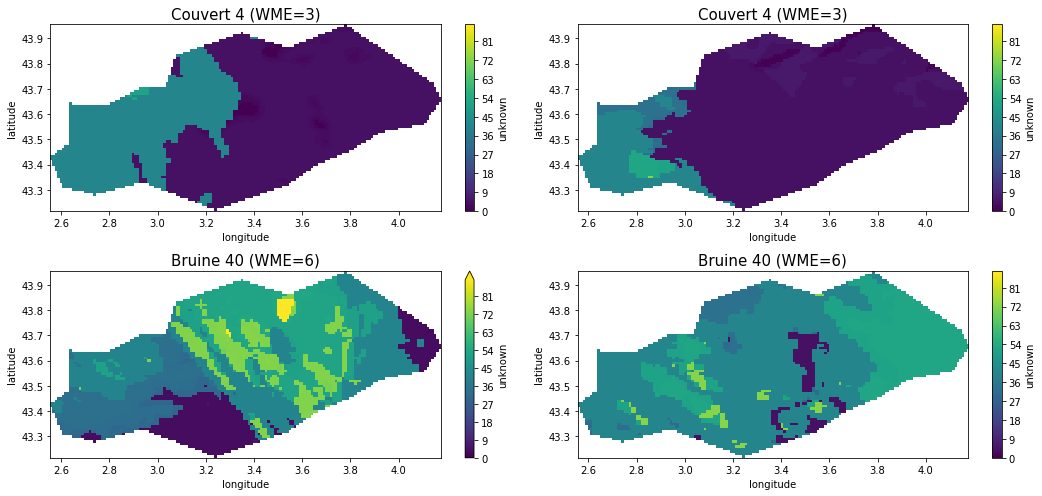

In [383]:
fig,axes = plt.subplots(nrows=2,ncols = 2,figsize=(15,7))
ax = axes.flat
for i in range(4):
    istep=4*i+2
    val = ds_ww_h.unknown.isel(step=istep).copy()
    code,leg = majoritaire(val.values, code_WWMF,legende_WWMF)
    val.plot.imshow(ax=ax[i],levels=range(0,90))
    ax[i].set_title(leg+' ' + str(code) + " (WME="+str(int(ds_ww_h.attrs["compas"][istep]))+")",fontsize=15)
plt.tight_layout()

In [2]:
# used to modify the name of a variable in a dataset
#import glob 
#path="../WWMF_backup/"
#files=sorted(glob.glob(path+"*"+'20200306000000'+"*"))
#file=files[0]
#print(file)
#ds_ww=xr.open_dataset(file)
#ds_ww
#ds_ww_sub=ds_ww.sel(latitude=slice(latmax,latmin,subsampgeo)).sel(longitude=slice(lonmin,lonmax,subsampgeo)).coarsen(step=subsampt,boundary="trim").median()
#ds_ww.rename({'paramId_0':'unknown'}).to_netcdf("../WWMF_backup/20200306000000__PG0PAROME__WWMF__EURW1S100______GRILLE____0_48_1__SOL____GRIB2_v2.nc")

In [94]:
# used to modify the name of a variable in a dataset
import glob 
path="../WWMF/"
files=sorted(glob.glob(path+"*"+'20200126000000'+"*"))
file=files[0]
print(file)
ds_ww=xr.open_dataset(file)
ds_ww['latitude']=ds_ww['latitude'].round(5)
ds_ww['longitude']=ds_ww['longitude'].round(5)
ds_ww

../WWMF/20200126000000__PG0PAROME__WWMF__EURW1S100______GRILLE____0_48_1__SOL____GRIB2.nc


<xarray.Dataset>
Dimensions:     (latitude: 1791, longitude: 2801, step: 48)
Coordinates:
    time        datetime64[ns] ...
  * step        (step) timedelta64[ns] 01:00:00 02:00:00 ... 2 days 00:00:00
    surface     int64 ...
  * latitude    (latitude) float64 55.4 55.39 55.38 55.37 ... 37.52 37.51 37.5
  * longitude   (longitude) float64 -12.0 -11.99 -11.98 ... 15.98 15.99 16.0
    valid_time  (step) datetime64[ns] ...
Data variables:
    unknown     (step, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             lfpw
    GRIB_centreDescription:  French Weather Service - Toulouse
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             French Weather Service - Toulouse
    history:                 2020-01-28T12:17:21 GRIB to CDM+CF via cfgrib-0....

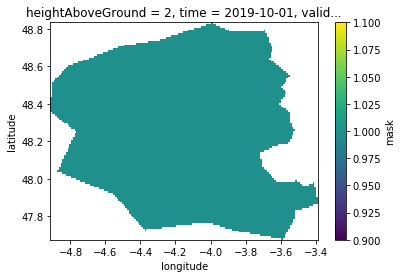

In [84]:
# explore les zones sympo
fname_mask = '../../../zones_sympo_multiples/29_mask_zones_sympos.nc'
ds_mask = xr.open_dataset(fname_mask)
ds_mask.mask.isel(id=0).plot.imshow()
ds_mask["latitude"]=ds_mask["latitude"].round(5)
ds_mask["longitude"]=ds_mask["longitude"].round(5)
#lat_center = ds_mask["latitude"].values.mean()
#lon_center = ds_mask["longitude"].values.mean()

In [112]:
ds_ww_h=ds_ww*ds_mask.mask.isel(id=0)
ds_ww_h

<xarray.Dataset>
Dimensions:            (latitude: 116, longitude: 153, step: 48)
Coordinates:
  * latitude           (latitude) float64 48.83 48.82 48.81 ... 47.7 47.69 47.68
  * longitude          (longitude) float64 -4.91 -4.9 -4.89 ... -3.41 -3.4 -3.39
  * step               (step) timedelta64[ns] 01:00:00 ... 2 days 00:00:00
    surface            int64 ...
    heightAboveGround  int64 2
    id                 <U11 'departement'
Data variables:
    unknown            (step, latitude, longitude) float32 nan nan ... nan nan

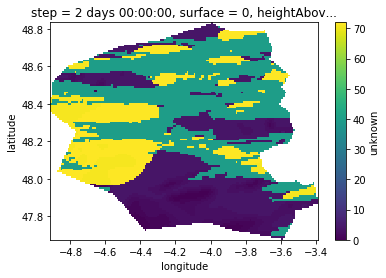

In [108]:
ds_ww_h.unknown.isel(step=47).plot.imshow()

In [127]:
ind=np.where(ds_ww_h.unknown==70)
ind

(array([21, 21, 21, 21, 21, 21, 21, 39, 39, 39, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42, 42,
        42, 42, 42, 42, 42, 42, 42, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43,
        43, 43, 43, 43, 43, 43, 43, 43, 43, 43, 43]),
 array([70, 70, 70, 70, 70, 70, 70, 88, 89, 90,  6,  8,  8,  8,  9,  9,  9,
         9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11,
        11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 28, 28, 28, 56, 56,
        56, 56, 57, 57, 57, 57, 57, 42, 42, 42, 43, 43, 43, 43, 43, 44, 44,
        44, 44, 44, 45, 45, 45, 45, 45, 46, 46, 46]),
 array([ 13,  14,  15,  16,  17,  18,  19,  33,  34,  34, 115, 105, 106,
        107,  97,  98,  99, 100, 101, 102, 103, 104,  93,  94,  95,  96,
         97,  98, 100, 101,  90,  91,  92,  93,  94,  95,  96,  82,  83,
         88,  89,  90,  91,  82,  83,  84, 104, 105, 106,  24,  2

In [121]:
ds_ww_h.isel(latitude=11).isel(longitude=49).isel(step=0).unknown

<xarray.DataArray 'unknown' ()>
array(32., dtype=float32)
Coordinates:
    latitude           float64 48.72
    longitude          float64 -4.42
    step               timedelta64[ns] 01:00:00
    surface            int64 ...
    heightAboveGround  int64 2
    id                 <U11 'departement'